In [8]:
#Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
#from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline




In [9]:
#Load text dataset
text_df = pd.read_csv('text_dataset.csv')
columns_to_drop_text = ['token_count', 'cleaned_subject']
text_df.drop(columns_to_drop_text, axis=1, inplace=True)
text_df

,label,cleaned_text,cleaned_title
0,1,donald trump met member nato go well moment ar...,watch trump shove foreign leader way get front...
1,0,washington reuters rick perry presidentelect d...,trump energy pick perry softens stance climate...
2,1,president obama blasted republican presidentia...,obama finally build border wallbut there one p...
3,1,male idaho republican five daughter made creep...,republican lawmaker say rape wont cause pregna...
4,1,kellyanne conway tried spin white house press ...,watch chuck todd swat annoying kellyanne conwa...
...,...,...,...
13829,0,washington reuters member u congress party fri...,u lawmaker back syria strike demand plan trump
13830,1,far video 530000 view make content legitimate ...,ups secretly fly refugee u middle east watch g...
13831,0,dec 27 story corrects say 55000 page email ins...,u appeal court revives clinton email suit
13832,0,madrid reuters spain high court said tuesday g...,spanish court grant u extradition russian hack...


In [113]:
text_df.dtypes

label             int64
cleaned_text     object
cleaned_title    object
dtype: object

# Relevant data preparation

Vectorize text columns and combine in feature matrix

In [10]:
# vectorize the text columns
tfidf_vectorizer_text = TfidfVectorizer()
tfidf_vectorizer_subject = TfidfVectorizer()
tfidf_vectorizer_title = TfidfVectorizer()

# transform each column
X_tfidf_text = tfidf_vectorizer_text.fit_transform(text_df['cleaned_text'])
# This is if for testing the models without cleaned_subject
# X_tfidf_subject = tfidf_vectorizer_subject.fit_transform(text_df['cleaned_subject'])
X_tfidf_title = tfidf_vectorizer_title.fit_transform(text_df['cleaned_title'])

# Combine TF-IDF from each column into feature matrix
X_tfidf_combined = hstack([X_tfidf_text, X_tfidf_title])

Split into train and test set

In [11]:
# Define label
y = text_df['label']

# split into test and train where test i 20% and train is 80%
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_combined, y, test_size=0.2, random_state=42)

# Dummy Classifier

In [116]:
# Train a baseline model (Dummy Classifier)
dummy_classifier = DummyClassifier(strategy="most_frequent")  # You can change the strategy as needed
dummy_classifier.fit(X_train, y_train)

# Make predictions
y_pred = dummy_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.4889772316588363
Classification Report:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      1353
           1       0.00      0.00      0.00      1414

    accuracy                           0.49      2767
   macro avg       0.24      0.50      0.33      2767
weighted avg       0.24      0.49      0.32      2767



/Users/andreasmaskine/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andreasmaskine/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andreasmaskine/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# MultinominalNB

In [117]:
# Create a pipeline that includes vectorization and the classifier
pipeline_MNNB = Pipeline([
    ('clf', MultinomialNB())
])

# Train the model
pipeline_MNNB.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline_MNNB.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9508492952656307
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      1353
           1       0.97      0.93      0.95      1414

    accuracy                           0.95      2767
   macro avg       0.95      0.95      0.95      2767
weighted avg       0.95      0.95      0.95      2767



### Performing GridSearch to find optimal parameters and apply these to optimize the MultinomialNB's performance

In [118]:
# Define the parameter grid to search
param_grid = {
    'clf__alpha': [0.01, 0.1, 1, 10, 100]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(pipeline_MNNB, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit it to the data
grid_search.fit(X_train, y_train)

# Print the best score and best parameters
print("Best score: %.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

# Evaluate the best grid search pipeline on the test data
y_pred = grid_search.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best score: 0.968
Best parameters set:
	clf__alpha: 0.01
Test Accuracy: 0.9696422117817131
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1353
           1       0.97      0.97      0.97      1414

    accuracy                           0.97      2767
   macro avg       0.97      0.97      0.97      2767
weighted avg       0.97      0.97      0.97      2767



# Logistic Regression

Create and train Logistic Regression model AND Analyzing the performance by using performance metrics

In [134]:
# Creating a pipeline with TF-IDF Vectorizer and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Convert text to TF-IDF coefficients
    ('clf', LogisticRegression(random_state=42))  # Classifier
])

# Fit the model on training data
pipeline.fit(X_train, y_train)

# Making predictions on the test data
y_pred = pipeline.predict(X_test)

# Output performance metrics
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1353
           1       0.99      0.99      0.99      1414

    accuracy                           0.99      2767
   macro avg       0.99      0.99      0.99      2767
weighted avg       0.99      0.99      0.99      2767

Confusion Matrix:
 [[1336   17]
 [  19 1395]]
Accuracy Score: 0.9869895193350199


In [135]:
# get coefficients of the model for interpretation
feature_names = tfidf_vectorizer_text.get_feature_names_out().tolist() \
                + tfidf_vectorizer_title.get_feature_names_out().tolist()

coefficients = logistic_regression_model.coef_.flatten()

feature_importance = dict(zip(feature_names, coefficients))

# Sort features by their values
sorted_feature_importance = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)

# top 10 positive and top 10 negative coefficients
print("Top 10 positive features: ", sorted_feature_importance[:10])
print("Top 10 negative features: ", sorted_feature_importance[-10:])

Top 10 positive features:  [('video', 6.162876491746599), ('breaking', 3.6985649780144176), ('hillary', 3.369676459161335), ('gop', 2.8363720631241116), ('watch', 2.7377581136974167), ('21st', 2.1562746673284106), ('muslim', 1.9750855494219133), ('america', 1.9425282633310499), ('obamas', 1.8179421238040867), ('obama', 1.791211449058231)]
Top 10 negative features:  [('lawmaker', -1.252729299187331), ('urge', -1.3153801668062934), ('talk', -1.4516531470914145), ('probe', -1.5403459599654779), ('china', -1.550531298196075), ('seek', -1.6031305924872423), ('declined', -1.6823937525440706), ('exclusive', -1.858790483833708), ('say', -2.34705035471496), ('factbox', -2.716477078020587)]


### Tuning of the Logistic Regression Model

In [138]:
# Create a dictionary of all values you want to test for C and penalty
param_grid = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Use 'clf__C' instead of 'logreg__C'
    'clf__penalty': ['l1', 'l2']  # Use 'clf__penalty' instead of 'logreg__penalty'
}

# Use GridSearchCV to search for the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit the grid search model with your training data
grid_search.fit(X_train, y_train)

# Output the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Optionally, evaluate the model on the test set
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ......................clf__C=0.001, clf__penalty=l1; total time=   1.7s
[CV] END ......................clf__C=0.001, clf__penalty=l1; total time=   1.8s
[CV] END ......................clf__C=0.001, clf__penalty=l1; total time=   1.8s
[CV] END ......................clf__C=0.001, clf__penalty=l1; total time=   1.9s
[CV] END ......................clf__C=0.001, clf__penalty=l1; total time=   1.9s
[CV] END ......................clf__C=0.001, clf__penalty=l2; total time=   2.5s
[CV] END ......................clf__C=0.001, clf__penalty=l2; total time=   2.5s
[CV] END ......................clf__C=0.001, clf__penalty=l2; total time=   2.6s
[CV] END .......................clf__C=0.01, clf__penalty=l1; total time=   2.2s
[CV] END .......................clf__C=0.01, clf__penalty=l1; total time=   2.1s
[CV] END .......................clf__C=0.01, clf__penalty=l1; total time=   2.0s
[CV] END ......................clf__C=0.001, clf

/Users/andreasmaskine/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ........................clf__C=100, clf__penalty=l2; total time=   4.4s
[CV] END ........................clf__C=100, clf__penalty=l2; total time=   3.9s
[CV] END ........................clf__C=100, clf__penalty=l2; total time=   4.3s


/Users/andreasmaskine/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ........................clf__C=100, clf__penalty=l2; total time=   3.1s
[CV] END ........................clf__C=100, clf__penalty=l2; total time=   3.4s


/Users/andreasmaskine/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/andreasmaskine/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/andreasmaskine/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/andreasmaskine/anaconda3/lib/python3.11/site-packa

Best Parameters: {'clf__C': 100, 'clf__penalty': 'l2'}
Best Score: 0.9906026269179697
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1353
           1       1.00      0.99      0.99      1414

    accuracy                           0.99      2767
   macro avg       0.99      0.99      0.99      2767
weighted avg       0.99      0.99      0.99      2767

Confusion Matrix:
 [[1348    5]
 [  10 1404]]
Accuracy Score: 0.9945789663895916


# Random Forest

In [99]:
# Train a Random Forest model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# Make predictions
y_pred = random_forest.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9873509215757138
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1353
           1       0.99      0.98      0.99      1414

    accuracy                           0.99      2767
   macro avg       0.99      0.99      0.99      2767
weighted avg       0.99      0.99      0.99      2767



Now we use gridSearch to find and use  the optimal hyperparameters, to increase the performance of the Random Forest model even more

In [100]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest classifier
random_forest = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}
Best Score: 0.9865365501039126
Accuracy: 0.9877123238164076
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1353
           1       0.99      0.98      0.99      1414

    accuracy                           0.99      2767
   macro avg       0.99      0.99      0.99      2767
weighted avg       0.99      0.99      0.99      2767



# BERT Model

In [4]:
# Splitting data into training and validation sets, tokenizing the text, and converting labels into a fitting format.
# Split data into training and validation sets
train_df, val_df = train_test_split(text_df, test_size=0.2, random_state=42)

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Encode the texts using tokenizer
        encoding = tokenizer(text, truncation=True, padding='max_length', max_length=512, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create dataset objects
train_dataset = NewsDataset(train_df['cleaned_text'].tolist(), train_df['label'].tolist())
val_dataset = NewsDataset(val_df['cleaned_text'].tolist(), val_df['label'].tolist())


In [5]:
#Creating data loaders to handle batching and shuffling the data for training and validation.
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [6]:
#Initializing a BERT pre-trained model
BERTmodel = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [6]:
#Below we define the training process, including forward and backward propagation.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BERTmodel.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

def train_epoch(model, data_loader, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(data_loader)

# Train the model (example for one epoch)
loss = train_epoch(model, train_loader, optimizer)
print(f"Training loss: {loss}")


/Users/claramillekalo/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 692/692 [5:36:41<00:00, 29.19s/it]    

Training loss: 0.05537884194423065


In [7]:
#Now we evaluate the model on the validation/test set
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in tqdm(data_loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct_predictions += torch.sum(predictions == batch['labels'])

    return total_loss / len(data_loader), correct_predictions.double() / len(data_loader.dataset)

val_loss, val_accuracy = evaluate(model, val_loader)
print(f"Validation loss: {val_loss}, Accuracy: {val_accuracy}")


100%|██████████| 173/173 [17:06<00:00,  5.94s/it]

Validation loss: 0.004552477456523628, Accuracy: 0.9992771955186122


In [7]:
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    predictions_list = []
    true_labels_list = []

    with torch.no_grad():
        for batch in tqdm(data_loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            
            predictions = torch.argmax(outputs.logits, dim=-1)
            predictions_list.append(predictions.cpu().numpy())
            true_labels_list.append(batch['labels'].cpu().numpy())

    predictions_array = np.concatenate(predictions_list)
    true_labels_array = np.concatenate(true_labels_list)
    return total_loss / len(data_loader), predictions_array, true_labels_array

# Evaluate the model
val_loss, predictions, true_labels = evaluate(model, val_loader)
print(f"Validation loss: {val_loss}")

# Computing a confusion matrix
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:\n", cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'model' is not defined

In [14]:
#Saving the model - right now commented out as it creates a big file that cannot be pushed to GitHub
#torch.save(model.state_dict(), 'bert_news_classifier.pth')
#model.load_state_dict(torch.load('bert_news_classifier.pth'))


<All keys matched successfully>

# SVM model

In [12]:
# Combine the text columns from our dataframe into one to better work with it and tokenize it
text_df['combined_text'] = text_df['cleaned_title'] + " " + text_df['cleaned_text']

# Define features and labels
X = text_df['combined_text']
y = text_df['label']


In [13]:
#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
# As SVM processes numerical values, we need to convert the text into numerical values.
# we do so by using TF-IDF
pipeline = make_pipeline(
    TfidfVectorizer(max_features=14000, ngram_range=(1,2)),
    SVC(kernel='linear', C=1.0)
)
#We use a linear kernel for SVM as it is efficient in high-dimensional data which is typical of text data

#Now we fit the model:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=14000, ngram_range=(1, 2))),
                ('svc', SVC(kernel='linear'))])

In [16]:
predictions = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))



Accuracy: 0.9945789663895916
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1353
           1       1.00      0.99      0.99      1414

    accuracy                           0.99      2767
   macro avg       0.99      0.99      0.99      2767
weighted avg       0.99      0.99      0.99      2767



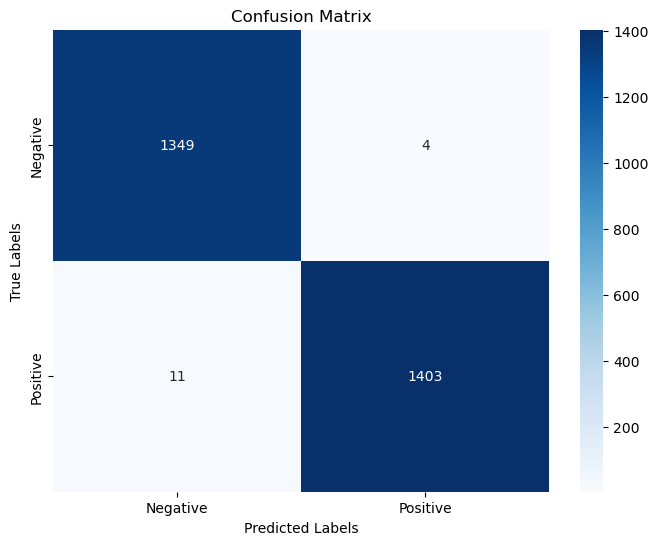

In [17]:
conf_mat = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()